## NCrystal materials in OpenMC

In this notebook we show how to use NCrystal materials in OpenMC.

## Preamble: install NCrystal, OpenMC and nuclear data

Install dependencies. This installation is done with mamba to include both OpenMC and NCrystal. Note that we only install OpenMC, and NCrystal is installed automatically. We also download the NNDC lightweight nuclear data library from OpenMC. Feel free to edit as you wish:

In [1]:
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if google_colab:
    print("WARNING: Installing mambaforge. This will cause your notebook "
          "to say it crashed and restart itself. This is expected behaviour!!")
    %pip -q install condacolab
    import condacolab
    condacolab.install_miniforge()
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab

import pathlib
import os
import shutil
import subprocess
if not shutil.which('openmc') or not shutil.which('nctool'):
    if not google_colab:
        raise RuntimeError('required dependencies not installed!')
    else:
        !mamba install openmc
#enable inline and interactive matplotlib plots and import NCrystal:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  4002000, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


Create a few utility functions needed below:

In [2]:
def download_file(url, tgt_path = None, skip_if_exists = False ):
    import requests
    tgt_path = pathlib.Path( tgt_path or url.split('/')[-1] )
    if tgt_path.is_file():
        if skip_if_exists:
            print(f"File already downloaded: {tgt_path.name}")
            return tgt_path
        tgt_path.unlink()
    print(f"Downloading: {tgt_path.name}")
    with requests.get(url, stream=True) as rh:
        rh.raise_for_status()
        with pathlib.Path(tgt_path).open('wb') as fh:
            for chunk in rh.iter_content(chunk_size=131072):
                fh.write(chunk)
    return tgt_path

def extract_archive( archive_path, dest ):
    import tarfile
    import sys
    dest = pathlib.Path(dest)
    print(f"Extracting {archive_path.name}")
    dest.mkdir( exist_ok = True, parents = True )
    kw = {'filter':'data'} if sys.version_info[0:2]>=(3,12) else {}
    with tarfile.open(archive_path, 'r') as th:
        th.extractall(path=dest,**kw)

Download nuclear data library (WARNING: This might take a few minutes):

In [3]:
openmc_xsfile = pathlib.Path('./nndc_hdf5/cross_sections.xml')
if not openmc_xsfile.is_file():
    f = download_file('https://anl.box.com/shared/static/teaup95cqv8s9nn56hfn7ku8mmelr95p.xz',
                      skip_if_exists = True )
    extract_archive( f, '.' )
assert openmc_xsfile.is_file()
print(f"OpenMC cross section file prepared in {openmc_xsfile}")

Downloading: teaup95cqv8s9nn56hfn7ku8mmelr95p.xz
Extracting teaup95cqv8s9nn56hfn7ku8mmelr95p.xz
OpenMC cross section file prepared in nndc_hdf5/cross_sections.xml


In [4]:
import numpy as np
import openmc
openmc.config['cross_sections'] = str(openmc_xsfile)

## Example: create an OpenMC material from NCrystal and plot the XS

Material
	ID             =	1
	Name           =	Aluminum Carbide
	Temperature    =	293.15
	Density        =	2.991295432522171 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	NCrystal conf  =	Al4C3_sg166_AluminiumCarbide.ncmat
	Nuclides       
	C0             =	0.42857142857142855 [ao]
	Al27           =	0.5714285714285714 [ao]



/some/where/miniforge3/envs/ncrystalnotebooks/lib/python3.12/site-packages/NCrystal/core.py:1276: NCrystalUserWarning: The .crossSectionNonOriented method is deprecated. Please use .crossSectionIsotropic or .xsect methods instead
  warn('The .crossSectionNonOriented method is deprecated.'


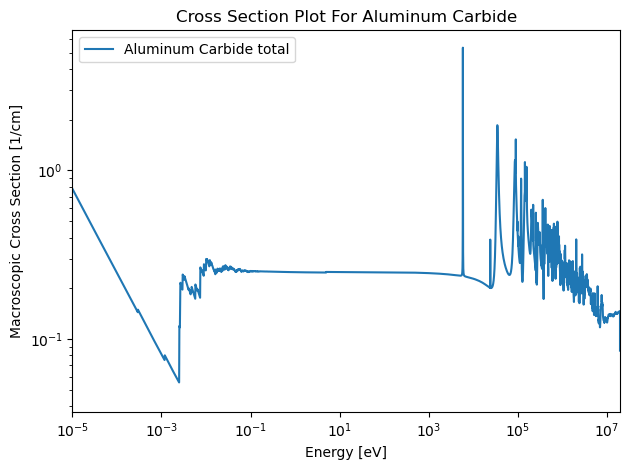

In [5]:
m = openmc.Material.from_ncrystal('Al4C3_sg166_AluminiumCarbide.ncmat')
m.name = 'Aluminum Carbide'
print(m)
_ = openmc.plot_xs({m:['total']})

We can also do this with a multiphase material. With NCrystal materials we do not have the limitation of only one S(a,b) treatment applied for each nuclide, like it happens with ACE files:

Material
	ID             =	2
	Name           =	
	Temperature    =	296.0
	Density        =	3.3871363782522765 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	NCrystal conf  =	phases<0.4*Al2O3_sg167_Corundum.ncmat&0.2*Al4C3_sg166_AluminiumCarbide.ncmat&0.2*AlN_sg186_AluminumNitride.ncmat&0.2*Al_sg225.ncmat>;temp=296
	Nuclides       
	C0             =	0.07829754095218704 [ao]
	N14            =	0.09963496463265756 [ao]
	N15            =	0.00036630464938010397 [ao]
	O16            =	0.294893335852394 [ao]
	O17            =	0.00011180694912177448 [ao]
	Al27           =	0.5266960469642594 [ao]



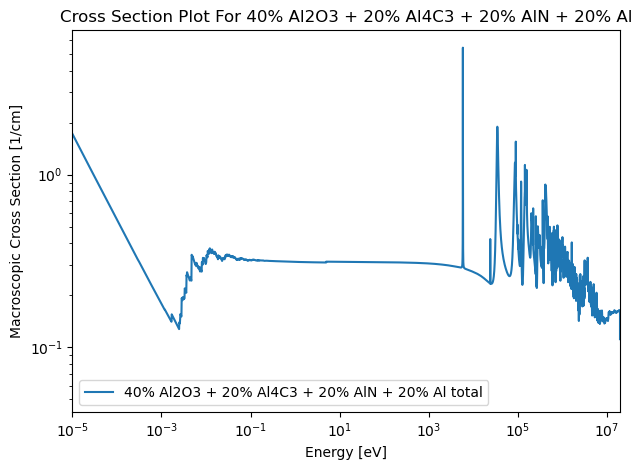

In [6]:
m = openmc.Material.from_ncrystal('phases<0.4*Al2O3_sg167_Corundum.ncmat&'
                                  '0.2*Al4C3_sg166_AluminiumCarbide.ncmat&'
                                  '0.2*AlN_sg186_AluminumNitride.ncmat&'
                                  '0.2*Al_sg225.ncmat>;temp=296K')
print(m)
m.name = '40% Al2O3 + 20% Al4C3 + 20% AlN + 20% Al'
_ = openmc.plot_xs({m:['total']})

## Example: Create a simple simulation in OpenMC

In [7]:
m = openmc.Material.from_ncrystal('Al_sg225.ncmat')
s = openmc.Sphere(r=10, boundary_type='vacuum')
c = openmc.Cell(region=-s, fill=m)
g = openmc.Geometry([c])
settings = openmc.Settings()
settings.source = openmc.IndependentSource()
settings.batches = 10
settings.particles = 100000
settings.run_mode = 'fixed source'
_ = openmc.Model(geometry=g, settings=settings).run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Example compute the diffraction pattern from a germanium single crystal

In this example we will simulate a beam of thermal neutrons incident on a cube of single crystal germanium. Downstream from the sample we will locate a 2D detector to compute the diffraction pattern.

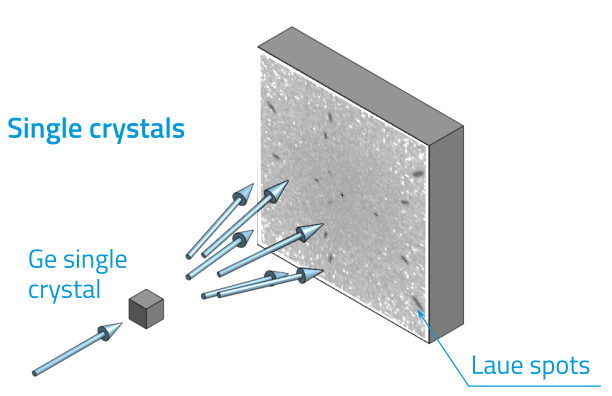

In [8]:

def compute_diffraction_pattern(m):
  side = 2 # cm
  s1 = openmc.model.OrthogonalBox([-side/2,-side/2,-side/2],
                                  [2*side/2, 0, 0],
                                  [0, 2*side/2, 0],
                                  [0, 0, 2*side/2])
  s99 = openmc.Sphere(r=1000*side/2, boundary_type='vacuum')
  c1 = openmc.Cell(region=-s1, fill=m)
  c99 = openmc.Cell(region=+s1&-s99, fill=None)
  g = openmc.Geometry([c1, c99])

  settings = openmc.Settings()
  source = openmc.IndependentSource()
  source.space = openmc.stats.Point((0,0,-50*side/2))
  source.energy = openmc.stats.Uniform(a=0.001, b=0.1)
  source.angle = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
  settings.source = source
  settings.batches = 10
  settings.particles = 100000
  settings.run_mode = 'fixed source'

  tal1 = openmc.Tally(name='2D detector')
  msh1 = openmc.RectilinearMesh()
  msh1.x_grid=np.linspace(-50*side, 50*side, 100)
  msh1.y_grid=np.linspace(-50*side, 50*side, 100)
  msh1.z_grid=[25*side, 25*side+1]
  tal1.filters = [openmc.MeshFilter(msh1)]
  tal1.scores = ['flux']

  tallies = openmc.Tallies([tal1])
  !rm summary.h5 statepoint.10.h5
  openmc.Model(geometry=g, settings=settings, tallies=tallies).run()

def plot_diffraction_pattern():
  df = openmc.StatePoint('statepoint.10.h5').get_tally(name='2D detector').get_pandas_dataframe()
  phi = df['mean'].values
  phi.shape = (99,99)
  import matplotlib.pyplot as plt
  import matplotlib.colors
  plt.figure()
  plt.imshow(phi,norm=matplotlib.colors.LogNorm(), cmap='Greys')
  plt.axis('off')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

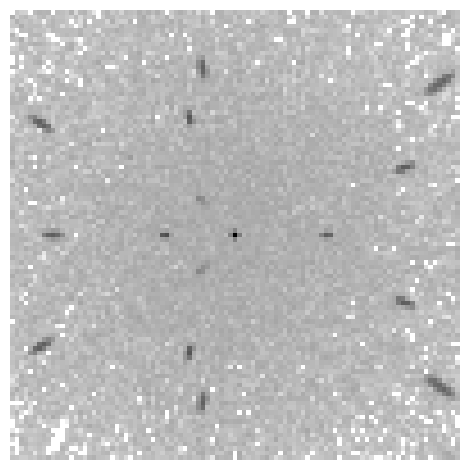

In [9]:
cfg = 'Ge_sg227.ncmat;mos=20.0arcmin;dir1=@crys_hkl:5,1,1@lab:0,0,1;dir2=@crys_hkl:0,-1,1@lab:0,1,0'
m = openmc.Material.from_ncrystal(cfg)

compute_diffraction_pattern(m)
plot_diffraction_pattern()

We can repeat the simulation without the configuration string parameters that give the orientation of the crystal. NCrystal understands then as a polycrystalline material (under the powder approximation) and we will rings the Debye-Scherrer that are a result of powder diffraction.

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

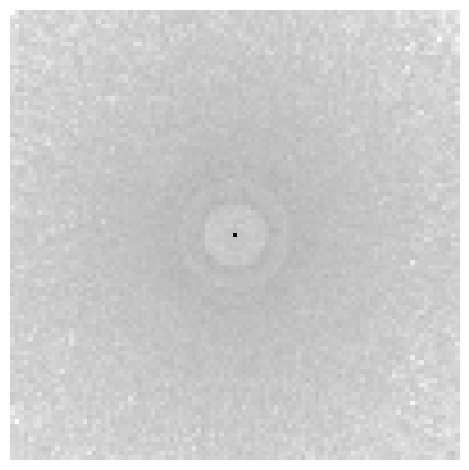

In [10]:
cfg = 'Ge_sg227.ncmat'
m = openmc.Material.from_ncrystal(cfg)

compute_diffraction_pattern(m)
plot_diffraction_pattern()